# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Add your name, student-id and emal address>

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
import time
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
#mean = np.random.uniform(-0.0005, 0.0005, N)
#A = np.random.uniform(0, 0.0113, size=(N, N))
mean = np.random.rand(N)
A = np.random.rand(N, N)
cov = np.dot(A, A.transpose())

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

print('multivariate normal shape =', data.shape)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
scalefactor = 1
expected_return = ExpectedReturn(method='arithmetic', scalefactor = scalefactor)
q =  expected_return.estimate(df, inplace = False)

# Compute the covariance matrix from df
covariance = Covariance(method='pearson')
P = covariance.estimate(df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)


multivariate normal shape = (1000, 100)
Vector of expected returns (q):
Asset_1      0.658292
Asset_2      0.816722
Asset_3      0.605577
Asset_4      0.463885
Asset_5      0.383594
               ...   
Asset_96     1.058108
Asset_97     1.001183
Asset_98     0.977864
Asset_99     0.819176
Asset_100    0.310840
Length: 100, dtype: float64

Covariance matrix (P):
             Asset_1    Asset_2    Asset_3    Asset_4    Asset_5    Asset_6  \
Asset_1    32.911855  24.354346  25.979983  24.572183  22.371771  26.029042   
Asset_2    24.354346  33.983937  26.640178  26.780596  24.351668  25.509272   
Asset_3    25.979983  26.640178  35.937595  25.908003  24.637301  25.570768   
Asset_4    24.572183  26.780596  25.908003  33.778205  22.512570  24.917725   
Asset_5    22.371771  24.351668  24.637301  22.512570  30.601785  24.168552   
...              ...        ...        ...        ...        ...        ...   
Asset_96   24.961878  23.884202  24.083373  22.471008  23.310326  26.873090   
As

In [3]:
# average return over all assets
print(q.mean(axis=0))

0.7080073217519763


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [4]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(np.zeros((3, N)), columns = constraints.ids)
G.iloc[0, 0:30] = 1
G.iloc[1, 30:60] = 1
G.iloc[2, 60:] = 1
h = pd.Series([0.3, 0.4, 0.5])

constraints.add_linear(G=G, rhs=h, sense='<=')

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [26]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results

#solver_array = qpsolvers.available_solvers # array of available solvers
solver_array = list(USABLE_SOLVERS)
print(solver_array)

data = {
    'solution_found': [False]*len(solver_array),
    'objective': [None] * len(solver_array),
    'primal_residual': [float('nan')] * len(solver_array),
    'dual_residual': [float('nan')] * len(solver_array),
    'duality_gap': [float('nan')] * len(solver_array),
    'runtime': [float('nan')] * len(solver_array),
}
Results_df  = pd.DataFrame(solver_array, index=data)
Results_df = Results_df.drop(Results_df.columns[0], axis=1)

risk_aversion = 1

cvxopt_weights = None

for solver in solver_array:
    qp = QuadraticProgram(
        P = P.to_numpy() * risk_aversion,
        q = q.to_numpy() * -1,
        G = GhAb['G'],
        h = GhAb['h'],
        A = GhAb['A'],
        b = GhAb['b'],
        lb = constraints.box['lower'].to_numpy(),
        ub = constraints.box['upper'].to_numpy(),
        solver = solver
    )
    
    start_time = time.time()
    qp.solve()
    end_time = time.time()

    execution_time = end_time - start_time

    solution = qp.results.get('solution')
    Results_df.loc['solution_found', solver] = solution.found

    if solution.found:
        Results_df.loc['objective', solver] = qp.objective_value()
        Results_df.loc['primal_residual', solver] = solution.primal_residual()
        Results_df.loc['dual_residual', solver] = solution.dual_residual()
        Results_df.loc['duality_gap', solver] = solution.duality_gap()
        Results_df.loc['runtime', solver] = execution_time
    
    # for Question 2
    if solver == 'cvxopt':
        cvxopt_weights = solution.x
        

['quadprog', 'osqp', 'daqp', 'highs', 'qpalm', 'cvxopt']


Print and visualize the results

,quadprog,osqp,daqp,highs,qpalm,cvxopt
solution_found,True,True,True,True,True,True
objective,9.919181,9.87915,9.919181,9.919181,9.918152,9.919182
primal_residual,0.0,0.000445,0.0,0.0,0.000027,0.0
dual_residual,0.0,0.001045,0.0,0.0,0.0,0.0
duality_gap,1.2398970739013748e-12,0.039718561825331726,8.810729923425242e-13,1.1436863900371463e-08,0.001028425208971615,8.155367136229589e-07
runtime,0.013,0.013025,0.003515,0.009995,0.009332,0.237027


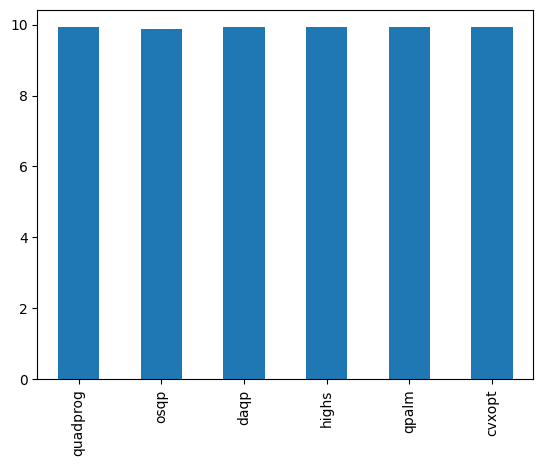

In [6]:
#<your code here>
Results_df.loc['objective'].plot(kind='bar')

Results_df

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [27]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        #<your code here>
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        self.objective = Objective(
            P = covmat # All that is needed for min-var optimization is the covariance matrix
        )
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            constraints = self.constraints
            GhAb = constraints.to_GhAb()
            obj_coeff = self.objective.coefficients

            Sigma =(obj_coeff['P']).to_numpy()
            A = GhAb['A']
            b = GhAb['b']
            
            try:
                # Analytical solution for weights as per lecture notes
                weights = np.linalg.inv(Sigma) @ A.T @ np.linalg.inv(A @ np.linalg.inv(Sigma) @ A.T) @ b
                self.results.update({
                    'weights': weights,
                    'status': True
                })        
                return None
            except:
                weights = [0]*len(Sigma)
                self.results.update({
                    'weights': weights,
                    'status': False
                })        
                return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
constraints_budget = Constraints(ids = df.columns.tolist())
constraints_budget.add_budget(rhs=[1], sense='=')

# Instantiate the MinVariance class
MinVar_portfolio = MinVariance(
    constraints=constraints_budget,
    #covariance=P, # COVARIANCE CLASS DEFINED / SET ABOVE GOES HERE
    solver_name='analytical'
)

# Prepare the optimization data and prepare the optimization problem
optimization_data = OptimizationData(return_series=df)
MinVar_portfolio.set_objective(optimization_data=optimization_data)

# Solve the optimization problem and print the weights
MinVar_portfolio.solve()
print(MinVar_portfolio.results.get('weights'))

mean_var_weights = cvxopt_weights

min_var_weights = MinVar_portfolio.results.get('weights')

# compare variance of solutions
mean_var_variance = mean_var_weights.T @ P @ mean_var_weights
min_var_variance = min_var_weights.T @ P @ min_var_weights
print('\n Variance of the mean variance optimal portfolio is', mean_var_variance)
print('Variance of the minimum variance portfolio is', min_var_variance)

# compare mean returns of expected solution
mean_var_returns = mean_var_weights.T @ q
min_var_returns = min_var_weights.T @ q
print('\n Mean return of the mean variance optimal portfolio is', mean_var_returns)
print('Mean return of the minimum variance portfolio is', min_var_returns)

# compare the budget constraints


[ 1.70237932 -0.65614124  0.96454979 -1.0502807   2.09440945 -2.82968009
  0.95345471  0.02457705 -1.6809375   0.61802366  2.21613491  0.27838035
 -0.64526901  1.41647217 -0.83084262 -2.60528214  0.65987702 -3.10180625
 -1.9081202   0.13084525  0.19547276 -0.42647582  2.6371936  -0.68926291
 -0.55340765 -2.50974621 -0.05041778 -0.76583322 -0.69791853 -1.02111695
  0.17878893  0.32915272 -2.83316587  1.39169812 -1.17782139  0.13515323
  0.47577537  1.12023505  0.77011847  1.83404409 -0.01197793  1.70471129
  1.10234793  1.15617196 -0.21888681  1.93114234 -1.1617956  -0.30638227
 -1.06913401 -2.89085287 -0.96785484  1.20206051  1.7905973   0.88377647
  1.42187248 -0.26968115  0.83130932 -0.7876141   2.70698725 -0.87658708
 -0.66790768  0.30560932  1.36910063 -0.50991182  0.05456337  0.83301122
 -2.77186776 -0.76941384 -2.23002484 -1.42535001  3.18324469 -1.16987618
  1.09467173 -0.32717274  0.1307261  -2.04519651 -1.83371246 -0.09638162
  0.04105738 -0.66150906  0.7672141   0.4756835   0